In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model, load_model
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.utils import shuffle
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [ ]:
try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

Import data


In [ ]:

pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data.csv', index_col=0)
df.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f86cbba1d3d1f336cdf9~12fffff.jpg,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032cc17f68194e605a26897~12fffff.jpg,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


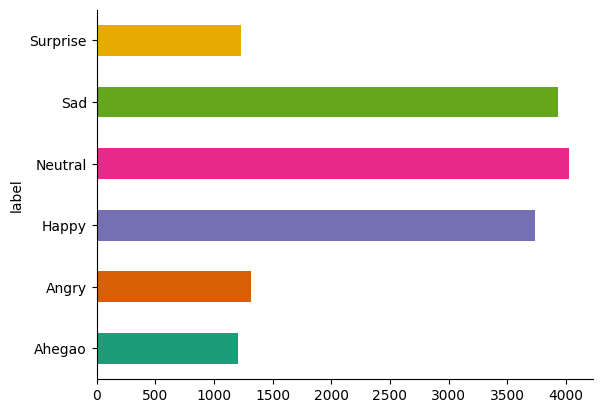

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
label_counts = df.groupby('label').size()
print(label_counts)

label
Ahegao      1205
Angry       1313
Happy       3740
Neutral     4027
Sad         3934
Surprise    1234
dtype: int64


In [ ]:
# train-test split
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=40, stratify=df['label'])

# Perform train-validation split on the train_val_df
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=40, stratify=train_val_df['label'])

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(12516, 2)
(1391, 2)
(1546, 2)


In [ ]:
max_class_count = train_df['label'].value_counts().max()

oversampled_dfs = []

for class_name, group in train_df.groupby('label'):
    oversampled_group = resample(group,
                                 replace=True,
                                 n_samples=max_class_count,
                                 random_state=42)
    oversampled_dfs.append(oversampled_group)

balanced_train_df = pd.concat(oversampled_dfs)
balanced_train_df = shuffle(balanced_train_df, random_state=40)


In [ ]:
# maximum class count
max_class_count = train_df['label'].value_counts().max()

# Initialize oversampled DataFrames
oversampled_dfs = []

# Loop over each class and perform oversampling
for class_name, group in train_df.groupby('label'):
    oversampled_group = resample(group,
                                 replace=True,
                                 n_samples=max_class_count,
                                 random_state=40)
    oversampled_dfs.append(oversampled_group)

# Concatenate oversampled DataFrames and shuffle
balanced_train_df = pd.concat(oversampled_dfs)
balanced_train_df = shuffle(balanced_train_df, random_state=42)

In [ ]:
class_counts = train_df.groupby('label').size()
print(class_counts)

label
Ahegao       976
Angry       1064
Happy       3029
Neutral     3261
Sad         3186
Surprise    1000
dtype: int64


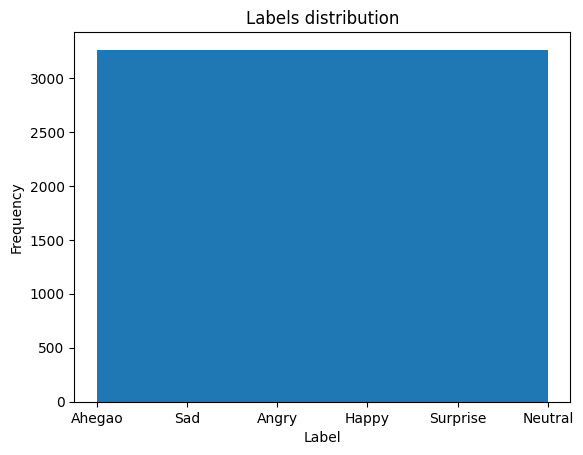

In [ ]:
plt.hist(balanced_train_df['label'], bins=len(balanced_train_df['label'].unique()))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Labels distribution')
plt.show()

In [ ]:
from skimage import exposure

def my_preprocessing_function(img):
    # Normalize image
    img_normalized = exposure.rescale_intensity(img)

    # Standardize image
    img_standardized = exposure.equalize_hist(img_normalized)

    return img_standardized

In [ ]:
df2='/content/drive/MyDrive/dataset'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=my_preprocessing_function
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=df2,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='categorical'
)

Found 19564 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
val_and_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=my_preprocessing_function
)

# Validation generator
validation_generator = val_and_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=df2,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='categorical'
)

# Test generator
test_generator = val_and_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=df2,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # its False for testing
)


Found 1390 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 1546 validated image filenames belonging to 6 classes.


In [ ]:
train_data_counts = balanced_train_df['label'].value_counts()
print(train_data_counts)


Ahegao      3261
Sad         3261
Angry       3261
Happy       3261
Surprise    3261
Neutral     3261
Name: label, dtype: int64


<ipython-input-18-8b19743df3a6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_data_counts.index, y=train_data_counts.values, palette='Set2')


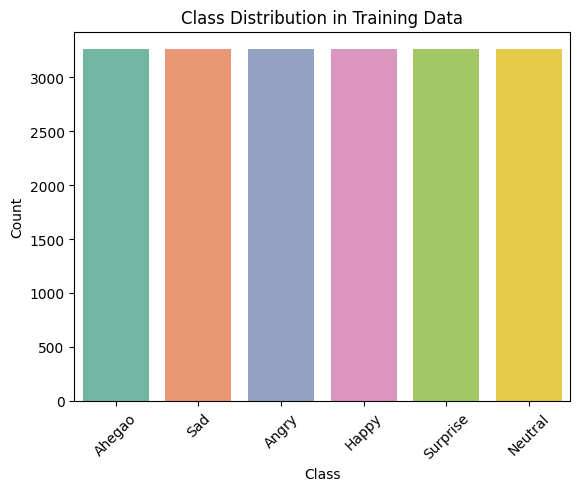

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the counts of each class in the training data
train_data_counts = balanced_train_df['label'].value_counts()

# bar plot using Seaborn
sns.barplot(x=train_data_counts.index, y=train_data_counts.values, palette='Set2')

# title and axis labels
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers except for the last two
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[reduce_lr, early_stop])

Epoch 1/5
306/306 [==============================] - 4630s 15s/step - loss: 1.8219 - accuracy: 0.1661 - val_loss: 1.7895 - val_accuracy: 0.2612 - lr: 0.0010
Epoch 2/5
306/306 [==============================] - 583s 2s/step - loss: 1.7921 - accuracy: 0.1623 - val_loss: 1.7873 - val_accuracy: 0.2612 - lr: 0.0010
Epoch 3/5
306/306 [==============================] - 564s 2s/step - loss: 1.7920 - accuracy: 0.1617 - val_loss: 1.7615 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 4/5
306/306 [==============================] - 563s 2s/step - loss: 1.7922 - accuracy: 0.1635 - val_loss: 1.7929 - val_accuracy: 0.0777 - lr: 0.0010
Epoch 5/5
306/306 [==============================] - 562s 2s/step - loss: 1.7920 - accuracy: 0.1640 - val_loss: 1.7932 - val_accuracy: 0.0777 - lr: 0.0010


In [ ]:
preds = base_model.predict(test_generator)
pred_cls = np.argmax(preds, axis=1)

true_cls = test_generator.classes
labels = list(test_generator.class_indices.keys())

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


25/25 [==============================] - 670s 28s/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Epoch 1/5
306/306 [==============================] - 743s 2s/step - loss: 1.7976 - accuracy: 0.1574 - val_loss: 1.9203 - val_accuracy: 0.2540 - lr: 1.0000e-05
Epoch 2/5
306/306 [==============================] - 724s 2s/step - loss: 1.7950 - accuracy: 0.1682 - val_loss: 1.8099 - val_accuracy: 0.0777 - lr: 1.0000e-05
Epoch 3/5
306/306 [==============================] - 724s 2s/step - loss: 1.7941 - accuracy: 0.1656 - val_loss: 1.8044 - val_accuracy: 0.2612 - lr: 1.0000e-05
Epoch 4/5
306/306 [==============================] - 716s 2s/step - loss: 1.7944 - accuracy: 0.1677 - val_loss: 1.7938 - val_accuracy: 0.2612 - lr: 1.0000e-05
Epoch 5/5
25/25 [==============================] - 36s 1s/step - loss: 1.7916 - accuracy: 0.2607
Test loss: 1.7915691137313843
Test accuracy: 0.2606727182865143
25/25 [==============================] - 47s 2s/step
              precision    recall  f1-score   support

      Ahegao       0.00      0.00      0.00       121
       Angry       0.00      0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


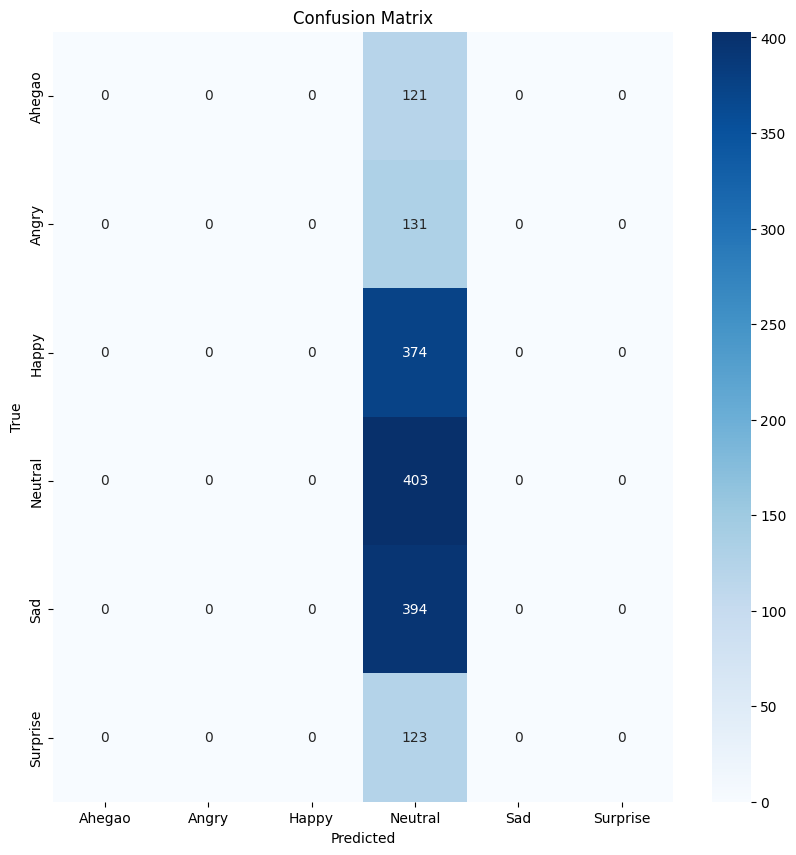

In [ ]:
# prompt: tune my model

import matplotlib.pyplot as plt
import numpy as np
# Fine-tune the model by unfreezing more layers
for layer in base_model.layers[150:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for additional epochs
epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[reduce_lr, early_stop])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Get predictions on the test set
preds = model.predict(test_generator)
pred_cls = np.argmax(preds, axis=1)

# Get true labels
true_cls = test_generator.classes

# Get class labels
labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_cls, pred_cls, target_names=labels))

# Plot the confusion matrix
cm = confusion_matrix(true_cls, pred_cls)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


25/25 [==============================] - 37s 1s/step


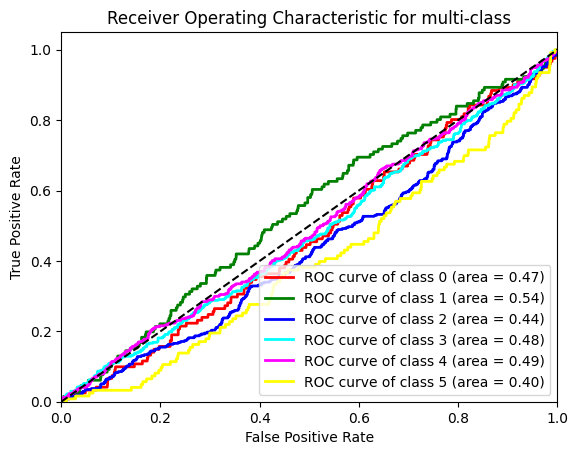

AUC scores:
Class 0: 0.47
Class 1: 0.54
Class 2: 0.44
Class 3: 0.48
Class 4: 0.49
Class 5: 0.40


In [ ]:
# AUC and ROC score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions for each class
predictions = model.predict(test_generator)

# Binarize the true labels
true_labels = label_binarize(test_generator.classes, classes=[0, 1, 2, 3, 4, 5])

# Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
lw = 2

for i, color in zip(range(6), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
print('AUC scores:')
for i in range(6):
    print('Class {0}: {1:0.2f}'.format(i, roc_auc[i]))

In [2]:
import os

model_path = "/content/drive/MyDrive/dataset/model_filename.hdf5"

if os.path.isfile(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")

Model file does not exist.


In [3]:
# where is my model saved

print(model_path)


/content/drive/MyDrive/dataset/model_filename.hdf5


In [ ]:
import numpy as np
import random

# Randomly select 50 indices from the test set
random_indices = random.sample(range(len(test_generator)), 50)

# Get the corresponding images and true labels
images = []
true_labels = []

for index in random_indices:
    image, label = test_generator[index]
    images.append(image)
    true_labels.append(label)

images = np.array(images)

# Predict labels for the selected images
predicted_labels = model.predict(images)

# Convert predicted labels to class predictions
predicted_classes = np.argmax(predicted_labels, axis=1)

# Map class indices to their corresponding class labels
class_labels = list(test_generator.class_indices.keys())

# Display actual and predicted labels for each image
for i in range(len(images)):
    print('Image', i+1)
    print('Actual Label:', class_labels[np.argmax(true_labels[i])])
    print('Predicted Label:', class_labels[predicted_classes[i]])
    print()
